In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from pathlib import Path
from keras.datasets import mnist
from keras import Model
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from models.dcec import DCEC
from sklearn.manifold import TSNE
import tensorflow as tf

Using TensorFlow backend.


In [2]:
img_rows, img_cols = 28, 28
batch_size = 128
(mnist_train_data, mnist_train_labels), (mnist_test_data, mnist_test_labels) = mnist.load_data()
mnist_train_data = mnist_train_data.reshape(mnist_train_data.shape[0], img_rows, img_cols, 1)
mnist_train_data = mnist_train_data.astype('float32')
mnist_train_data /= 255
mnist_test_data = mnist_test_data.reshape(mnist_test_data.shape[0], img_rows, img_cols, 1)
mnist_test_data = mnist_test_data.astype('float32')
mnist_test_data /= 255
print(f'MNIST train shape:  {mnist_train_data.shape}')
print(f'MNIST validation shape: {mnist_test_data.shape}')

MNIST train shape:  (60000, 28, 28, 1)
MNIST validation shape: (10000, 28, 28, 1)


In [3]:
dcec = keras.models.Sequential()
dcec.add(keras.layers.Conv2D(filters=32, kernel_size=5, strides=2, input_shape=(28, 28, 1), activation='relu', padding='same', name='conv1'))
dcec.add(keras.layers.Conv2D(filters=64, kernel_size=5, strides=2, activation='relu', padding='same', name='conv2'))
dcec.add(keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, activation='relu', padding='valid', name='conv3'))
dcec.add(keras.layers.Flatten())
dcec.add(keras.layers.Dense(units=10, name='dense1'))
dcec.add(keras.layers.Lambda(lambda x: tf.keras.backend.l2_normalize(x, axis=0), name='embeddings'))
dcec.add(keras.layers.Dense(units=128 * int(28/8) * int(28/8), activation='relu', name='dense2'))
dcec.add(keras.layers.Reshape( (int(28/8), int(28/8), 128) ))
dcec.add(keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='valid', activation='relu', name='tp1'))
dcec.add(keras.layers.Conv2DTranspose(filters=32, kernel_size=5, strides=2, padding='same', activation='relu', name='tp2'))
dcec.add(keras.layers.Conv2DTranspose(filters=1, kernel_size=5, strides=2, padding='same', activation='relu', name='tp3'))
dcec.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 14, 14, 32)        832       
_________________________________________________________________
conv2 (Conv2D)               (None, 7, 7, 64)          51264     
_________________________________________________________________
conv3 (Conv2D)               (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense1 (Dense)               (None, 10)                11530     
_________________________________________________________________
embeddings (Lambda)          (None, 10)                0         
________________________________________________

In [4]:
dcec.compile(optimizer='adam',
              loss='mse')
dcec.fit(mnist_train_data, 
         mnist_train_data, 
         batch_size=batch_size, 
         epochs=100,
         verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
60000/60000 [==============================] - 79s 1ms/step - loss: 0.0372


In [5]:
encoder = keras.Model(inputs=dcec.input, outputs=dcec.get_layer(name='embeddings').output)
embeddings = encoder.predict(mnist_test_data) 

print(f'Embeddings shape: {embeddings.shape}')
clusters = KMeans(n_clusters=10).fit_transform(embeddings)
print(f'Clusters shape: {clusters.shape}')

Embeddings shape: (10000, 10)
Clusters shape: (10000, 10)


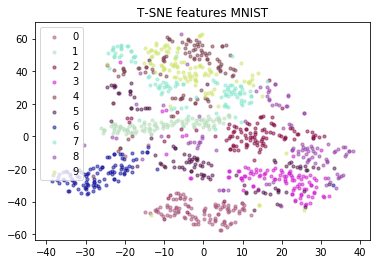

In [6]:
def plot_tsne(data: np.ndarray,
              labels: np.ndarray,
              dataset_name: np.ndarray,
              num_samples_per_class: int = 100) -> None:
    unique_labels = np.unique(labels)
    x_tsne = np.array([])
    for i in range(len(unique_labels)):
        label_ix = np.argwhere(unique_labels[i] == labels).flatten()
        random_labels_ix = np.random.choice(label_ix, num_samples_per_class)
        random_label_data = data[random_labels_ix, :]
        random_label_data = np.reshape(random_label_data, (num_samples_per_class, -1))
        if i == 0:
            x_tsne = random_label_data
        else:
            x_tsne = np.vstack((x_tsne, random_label_data))
    tsne_emb = TSNE(n_components=2).fit_transform(x_tsne)
    for i in range(len(unique_labels)):
        rgb = np.random.rand(3,)
        start_slice = (i)*num_samples_per_class
        stop_slice = (i+1)*num_samples_per_class
        x_plot = tsne_emb[()]
        plt.scatter(tsne_emb[start_slice:stop_slice, 0], tsne_emb[start_slice:stop_slice,1], c=[rgb], s=10, alpha=0.5)
    plt.title(f'T-SNE features {dataset_name}')
    plt.legend(unique_labels)
    plt.show()
    
plot_tsne(mnist_test_data, 
          mnist_test_labels, 
          dataset_name='MNIST',
          num_samples_per_class=100)

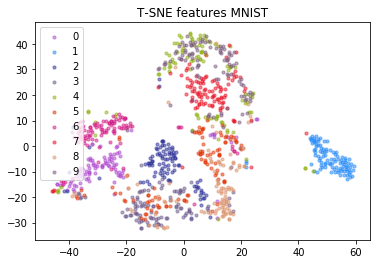

In [7]:
plot_tsne(clusters, 
          mnist_test_labels, 
          dataset_name='MNIST',
          num_samples_per_class=100)

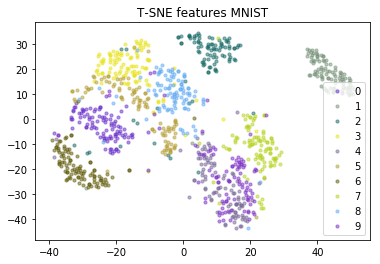

In [8]:
plot_tsne(embeddings, 
          mnist_test_labels, 
          dataset_name='MNIST',
          num_samples_per_class=100)

In [9]:
dcec.save_weights('DCECadam100epochs.h5')

NameError: name 'dcec_adam' is not defined